# Prepartions

In [1]:
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import HuberRegressor
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
import matplotlib.dates as mdates
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import ParameterGrid
from datetime import datetime
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed
import gc
from sklearn import ensemble


In [2]:
df_final = pd.read_csv("C:/Users/CMert/Documents/Data bachelorprojekt/The complete dataframe/df_final_cleaned_combined_2_endofmonth.csv")

df_final['Adj Close t+1'] = df_final.groupby("Symbol")["Adj Close"].shift(-1)

df_final = df_final.dropna(subset=['Adj Close t+1']).reset_index(drop=True)

df_final = df_final[df_final['1-month momentum'] != 0]

df_final['Date'] = pd.to_datetime(df_final['Date'])

df_final = df_final.sort_values(by='Date').reset_index(drop=True)

df_final = df_final[df_final['Adj Close t+1'] <= df_final["Adj Close t+1"].quantile(0.985)]

variables = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends',
       'Stock Splits', 'Market capitalization', 'Revenue', 'Earnings',
       'P/E ratio', 'P/B ratio', 'Operating Margin', 'EPS',
       'Shares Outstanding', 'Total assets', 'Total liabilities', 'Total debt',
       'Cash on Hand', 'Net assets', '1-month momentum', '6-month momentum',
       '12-month momentum', '36-month momentum', 'Book-to-market', 'Size']

df_final[variables] = df_final[variables].replace([np.inf, -np.inf], np.nan)

non_negative_variables = [
    'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends',
    'Stock Splits', 'Market capitalization', 'Revenue', 'EPS',
    'Shares Outstanding', 'Total assets', 'Total liabilities', 'Total debt',
    'Cash on Hand', 'Net assets'
]

df_final[non_negative_variables] = df_final[non_negative_variables].applymap(lambda x: max(x, 0))


funda_cols = [
    'Market capitalization', 'Revenue', 'Earnings', 'P/E ratio', 'P/B ratio',
    'Operating Margin', 'EPS', 'Shares Outstanding', 'Total assets',
    'Total liabilities', 'Total debt', 'Cash on Hand', 'Net assets'
]

df_final[funda_cols] = (
    df_final.groupby('Symbol')[funda_cols]
      .shift(12))

df_final = df_final.dropna(subset=variables).reset_index(drop=True)


In [3]:
df_final

,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,Sector,...,Cash on Hand,Net assets,1-month momentum,6-month momentum,12-month momentum,36-month momentum,Book-to-market,Size,Symbol,Adj Close t+1
0,1997-02-28,0.150670,0.150670,0.145089,0.145089,0.122524,121878400.0,0.0,0.0,Technology,...,1.740000e+09,0.000000e+00,-0.002828,0.006597,0.012723,0.102261,10.516756,0.000000,AAPL,0.137604
1,1997-02-28,6.937500,6.937500,6.812500,6.812500,2.242910,9400.0,0.0,0.0,Consumer Discretionary,...,4.700000e+06,8.849816e+07,-0.022543,0.019197,0.394677,1.072677,0.668527,18.906044,SGC,2.140023
2,1997-02-28,39.187500,39.312500,38.375000,39.312500,32.637779,494200.0,0.0,0.0,Finance,...,1.400000e+08,2.293864e+09,2.040556,13.065813,25.626753,3.814121,0.645497,22.474418,MTG,29.368822
3,1997-02-28,10.625000,10.937500,10.562500,10.875000,10.332757,159200.0,0.0,0.0,Technology,...,5.300000e+06,9.747199e+07,-1.425210,6.354053,6.057135,5.700832,0.062723,19.351977,NICE,9.738921
4,1997-02-28,31.500000,31.500000,30.687500,30.687500,9.806581,22000.0,0.0,0.0,Finance,...,6.967000e+07,0.000000e+00,1.078525,3.761210,6.900859,4.914822,0.355534,21.321768,MCY,9.791734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711296,2024-08-30,38.150002,38.590000,37.830002,38.580002,38.580002,539900.0,0.0,0.0,Utilities,...,2.700000e+08,3.020000e+09,-1.464996,3.577999,5.195873,-2.139236,0.021338,21.436014,WES,38.299999
711297,2024-08-30,30.900000,31.200001,30.209999,30.440001,30.440001,2364900.0,0.0,0.0,Consumer Discretionary,...,6.953566e+08,1.731511e+09,1.089708,0.321186,15.223827,30.727109,0.105255,22.685456,HTHT,29.340000
711298,2024-08-30,6.690000,6.880000,6.670000,6.860000,6.860000,4055300.0,0.0,0.0,Technology,...,3.700000e+08,5.990000e+09,0.120000,0.380000,-3.950000,13.850000,0.341980,21.832332,CLVT,6.550000
711299,2024-08-30,51.099998,51.250000,49.590000,50.919998,50.919998,1494400.0,0.0,0.0,Technology,...,3.700000e+08,1.760000e+09,-1.520000,14.780001,4.780000,-2.470000,-0.115780,20.748237,CLS,43.490002


# The sampling algorithm

In [4]:

def recursive_rolling_method(data, initial_date, date_column='Date', 
         train_period = 24, val_period = 24, test_period = 12, freq = 'months'):
    
                
    train_indices_list = []
    val_indices_list = []
    test_indices_list = []

    
    # Define initial interval
    start_train = initial_date
    end_train = start_train + relativedelta(**{freq: train_period})
    
    start_val = end_train + relativedelta(months=1)
    end_val = start_val + relativedelta(**{freq: val_period})
    
    start_test = end_val + relativedelta(months=1)
    end_test = start_test + relativedelta(**{freq: test_period})

    
    while start_test  < data[date_column].max():   
        cur_train_indices = list(data[(data[date_column] >= start_train) & 
                              (data[date_column] < end_train)].index)

        cur_val_indices = list(data[(data[date_column] >= start_val) & 
                                    (data[date_column] < end_val)].index)

        cur_test_indices = list(data[(data[date_column] >= start_test) & 
                                    (data[date_column] < end_test)].index)

        
        print("    Train period:",start_train, "-" , end_train, 
            " || Val period:",start_val, "-" , end_val, 
            " || Test period", start_test, "-", end_test,
            " || Train contains", len(cur_train_indices),
            " || Val contains", len(cur_val_indices) , 
            " || Test contains", len(cur_test_indices))

        train_indices_list.append(cur_train_indices)
        val_indices_list.append(cur_val_indices)
        test_indices_list.append(cur_test_indices)
        
        
        # Define next interval
        
        filler_unit = 1
        start_train = start_train + relativedelta(**{freq: filler_unit}) #  -  this only goes one period ahead for each interval, so they overlap
        
        # start_train = end_test
        end_train = start_train + relativedelta(**{freq: train_period})  
        
        start_val = end_train + relativedelta(months=1)
        end_val = start_val + relativedelta(**{freq: val_period})
            
        start_test = end_val + relativedelta(months=1)
        end_test = start_test + relativedelta(**{freq: test_period})

    # Ensure we have the same output as sklearn sampling packages, since we will use its regressors
    index_output = [(train,val,test) for train,val,test in zip(train_indices_list,val_indices_list,test_indices_list)]
    
    return index_output


In [5]:
# Create the top and bottom firms by market cap:

top_symbols = (
    df_final.groupby('Symbol')['Market capitalization'].last() 
    .nlargest(500)  
    .index 
)


df_top_500 = df_final[df_final['Symbol'].isin(top_symbols)].reset_index(drop=True)



bottom_symbols = (
    df_final.groupby('Symbol')['Market capitalization'].last() 
    .nsmallest(500)  
    .index 
)


df_bottom_500 = df_final[df_final['Symbol'].isin(bottom_symbols)].reset_index(drop=True)

In [81]:
df_final.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Dividends', 'Stock Splits', 'Sector', 'Industry',
       'Market capitalization', 'Revenue', 'Earnings', 'P/E ratio',
       'P/B ratio', 'Operating Margin', 'EPS', 'Shares Outstanding',
       'Total assets', 'Total liabilities', 'Total debt', 'Cash on Hand',
       'Net assets', '1-month momentum', '6-month momentum',
       '12-month momentum', '36-month momentum', 'Book-to-market', 'Size',
       'Symbol', 'Adj Close t+1'],
      dtype='object')

# GBRT algorithm for all stocks

In [7]:

X = df_final[['Date'] + variables]
y = df_final["Adj Close t+1"]


X['Date'] = pd.to_datetime(X['Date'])

initial_date = X['Date'].min()


predictions = []
y_test_list = []
dates = []
num_of_char = {}



for split_num, (train_index, val_index, test_index) in enumerate(recursive_rolling_method(X,initial_date,date_column='Date',train_period=8,val_period=3,test_period=1,freq='years')):
    X_train = X.loc[train_index].drop('Date', axis=1)
    y_train = y.loc[train_index]

    X_val = X.loc[val_index].drop('Date', axis=1)
    y_val = y.loc[val_index].astype('float32')

    X_test = X.loc[test_index].drop('Date', axis=1)
    y_test = y.loc[test_index]


    gbrt = GradientBoostingRegressor(n_estimators=300, max_depth=8, min_samples_split=5, learning_rate=0.01, loss="huber", n_iter_no_change=7, validation_fraction=0.2)
    
    gbrt.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
    
    preds = gbrt.predict(X_test)
   
    predictions.append(preds)  
    date_series = pd.Series(X.loc[y_test.index, 'Date'].values, index=y_test.index, name='Date')
    dates.append(date_series)
    y_test_list.append(y_test)


   
    test_date = X.loc[y_test.index, 'Date'].iloc[-1]
    num_trees = gbrt.get_params()['n_estimators']
    num_of_char[f"ntrees.{test_date.strftime('%Y-%m-%d')}"] = num_trees

   
    del X_train, y_train, X_val, y_val, gbrt, preds
    gc.collect()


    print(f"Completed {split_num + 1} splits.")
   
predictions_all = np.concatenate(predictions, axis=0)
y_test_list_all = pd.concat(y_test_list, axis=0)
dates_all = pd.concat(dates, axis=0)


R2oos_GBRT = 1 - np.sum(np.power(y_test_list_all - predictions_all, 2)) / np.sum(np.power(y_test_list_all, 2))
print("R2_oos GBRT:", R2oos_GBRT)


    Train period: 1997-02-28 00:00:00 - 2005-02-28 00:00:00  || Val period: 2005-03-28 00:00:00 - 2008-03-28 00:00:00  || Test period 2008-04-28 00:00:00 - 2009-04-28 00:00:00  || Train contains 128010  || Val contains 61539  || Test contains 22567
    Train period: 1998-02-28 00:00:00 - 2006-02-28 00:00:00  || Val period: 2006-03-28 00:00:00 - 2009-03-28 00:00:00  || Test period 2009-04-28 00:00:00 - 2010-04-28 00:00:00  || Train contains 134251  || Val contains 64366  || Test contains 23241
    Train period: 1999-02-28 00:00:00 - 2007-02-28 00:00:00  || Val period: 2007-03-28 00:00:00 - 2010-03-28 00:00:00  || Test period 2010-04-28 00:00:00 - 2011-04-28 00:00:00  || Train contains 140750  || Val contains 67126  || Test contains 23622
    Train period: 2000-02-28 00:00:00 - 2008-02-28 00:00:00  || Val period: 2008-03-28 00:00:00 - 2011-03-28 00:00:00  || Test period 2011-04-28 00:00:00 - 2012-04-28 00:00:00  || Train contains 148520  || Val contains 69265  || Test contains 24547
    

# GBRT algorithm for top 500 stocks

In [84]:

X = df_top_500[['Date'] + variables]
y = df_top_500['Adj Close t+1']


X['Date'] = pd.to_datetime(X['Date'])

initial_date = X['Date'].min()


predictions = []
y_test_list = []
dates = []
num_of_char = {}



for split_num, (train_index, val_index, test_index) in enumerate(recursive_rolling_method(X,initial_date,date_column='Date',train_period=8,val_period=3,test_period=1,freq='years')):
    X_train = X.loc[train_index].drop('Date', axis=1)
    y_train = y.loc[train_index]

    X_val = X.loc[val_index].drop('Date', axis=1)
    y_val = y.loc[val_index].astype('float32')

    X_test = X.loc[test_index].drop('Date', axis=1)
    y_test = y.loc[test_index]


    gbrt = GradientBoostingRegressor(n_estimators=300, max_depth=8, min_samples_split=5,
                                  learning_rate=0.01, loss="huber", n_iter_no_change=7, validation_fraction=0.2)
    
    gbrt.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
    
    preds = gbrt.predict(X_test)
   
    predictions.append(preds)  
    date_series = pd.Series(X.loc[y_test.index, 'Date'].values, index=y_test.index, name='Date')
    dates.append(date_series)
    y_test_list.append(y_test)


   
    test_date = X.loc[y_test.index, 'Date'].iloc[-1]
    num_trees = gbrt.get_params()['n_estimators']
    num_of_char[f"ntrees.{test_date.strftime('%Y-%m-%d')}"] = num_trees

   
    del X_train, y_train, X_val, y_val, gbrt, preds
    gc.collect()


    print(f"Completed {split_num + 1} splits.")
   
predictions_all = np.concatenate(predictions, axis=0)
y_test_list_all = pd.concat(y_test_list, axis=0)
dates_all = pd.concat(dates, axis=0)


R2oos_GBRT_top = 1 - np.sum(np.power(y_test_list_all - predictions_all, 2)) / np.sum(np.power(y_test_list_all, 2))
print("R2_oos GBRT Top 500: ", R2oos_GBRT_top)

    Train period: 1996-02-29 00:00:00 - 2004-02-29 00:00:00  || Val period: 2004-02-29 00:00:00 - 2007-02-28 00:00:00  || Test period 2007-02-28 00:00:00 - 2008-02-28 00:00:00  || Train contains 29728  || Val contains 12730  || Test contains 4600
    Train period: 1997-02-28 00:00:00 - 2005-02-28 00:00:00  || Val period: 2005-02-28 00:00:00 - 2008-02-28 00:00:00  || Test period 2008-02-28 00:00:00 - 2009-02-28 00:00:00  || Train contains 30549  || Val contains 13422  || Test contains 5116
    Train period: 1998-02-28 00:00:00 - 2006-02-28 00:00:00  || Val period: 2006-02-28 00:00:00 - 2009-02-28 00:00:00  || Test period 2009-02-28 00:00:00 - 2010-02-28 00:00:00  || Train contains 31419  || Val contains 14186  || Test contains 4764
    Train period: 1999-02-28 00:00:00 - 2007-02-28 00:00:00  || Val period: 2007-02-28 00:00:00 - 2010-02-28 00:00:00  || Test period 2010-02-28 00:00:00 - 2011-02-28 00:00:00  || Train contains 32418  || Val contains 14480  || Test contains 4497
    Train pe

# GBRT algorithm for bottom 500 stocks

In [85]:

X = df_bottom_500[['Date'] + variables]
y = df_bottom_500['Adj Close t+1']

X['Date'] = pd.to_datetime(X['Date'])

initial_date = X['Date'].min()


predictions = []
y_test_list = []
dates = []
num_of_char = {}



for split_num, (train_index, val_index, test_index) in enumerate(recursive_rolling_method(X,initial_date,date_column='Date',train_period=8,val_period=3,test_period=1,freq='years')):
    X_train = X.loc[train_index].drop('Date', axis=1)
    y_train = y.loc[train_index]

    X_val = X.loc[val_index].drop('Date', axis=1)
    y_val = y.loc[val_index].astype('float32')

    X_test = X.loc[test_index].drop('Date', axis=1)
    y_test = y.loc[test_index]


    gbrt = GradientBoostingRegressor(n_estimators=300, max_depth=8, min_samples_split=5,
                                  learning_rate=0.01, loss="huber", n_iter_no_change=7, validation_fraction=0.2)
    
    gbrt.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
    
    preds = gbrt.predict(X_test)
   
    predictions.append(preds)  
    date_series = pd.Series(X.loc[y_test.index, 'Date'].values, index=y_test.index, name='Date')
    dates.append(date_series)
    y_test_list.append(y_test)


   
    test_date = X.loc[y_test.index, 'Date'].iloc[-1]
    num_trees = gbrt.get_params()['n_estimators']
    num_of_char[f"ntrees.{test_date.strftime('%Y-%m-%d')}"] = num_trees

   
    del X_train, y_train, X_val, y_val, gbrt, preds
    gc.collect()
    

    print(f"Completed {split_num + 1} splits.")
   
predictions_all = np.concatenate(predictions, axis=0)
y_test_list_all = pd.concat(y_test_list, axis=0)
dates_all = pd.concat(dates, axis=0)


R2oos_GBRT_bottom = 1 - np.sum(np.power(y_test_list_all - predictions_all, 2)) / np.sum(np.power(y_test_list_all, 2))
print("R2_oos GBRT bottom 500: ", R2oos_GBRT_bottom)

    Train period: 1996-02-29 00:00:00 - 2004-02-29 00:00:00  || Val period: 2004-02-29 00:00:00 - 2007-02-28 00:00:00  || Test period 2007-02-28 00:00:00 - 2008-02-28 00:00:00  || Train contains 6493  || Val contains 3356  || Test contains 1330
    Train period: 1997-02-28 00:00:00 - 2005-02-28 00:00:00  || Val period: 2005-02-28 00:00:00 - 2008-02-28 00:00:00  || Test period 2008-02-28 00:00:00 - 2009-02-28 00:00:00  || Train contains 6961  || Val contains 3676  || Test contains 1584
    Train period: 1998-02-28 00:00:00 - 2006-02-28 00:00:00  || Val period: 2006-02-28 00:00:00 - 2009-02-28 00:00:00  || Test period 2009-02-28 00:00:00 - 2010-02-28 00:00:00  || Train contains 7423  || Val contains 4107  || Test contains 1534
    Train period: 1999-02-28 00:00:00 - 2007-02-28 00:00:00  || Val period: 2007-02-28 00:00:00 - 2010-02-28 00:00:00  || Test period 2010-02-28 00:00:00 - 2011-02-28 00:00:00  || Train contains 7910  || Val contains 4448  || Test contains 1459
    Train period: 20

In [86]:
R2oos_OLS_df = pd.DataFrame({
    "ENet +H" : [R2oos_GBRT,
                R2oos_GBRT_top,
                R2oos_GBRT_bottom
                ]
})

R2oos_OLS_df.index = ['Alle', "Øverste 500", "Nederste 500"]

In [87]:
R2oos_OLS_df

,ENet +H
Alle,0.544072
Øverste 500,0.803733
Nederste 500,0.523659


In [88]:
R2oos_OLS_df.to_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/R2-værdier/R2oos_GBRT.csv", index=False)

# Variable importance

In [7]:

# We only use the last interval:

X_train = df_final[variables].loc[(df_final["Date"] >= '2013-02-28') & (df_final["Date"] < '2021-02-28')]
y_train = df_final["Adj Close t+1"].loc[(df_final["Date"]>='2013-02-28') & (df_final["Date"] < '2021-02-28')]

X_val = df_final[variables].loc[(df_final["Date"] >= '2021-02-28') & (df_final["Date"] < '2024-02-28')]
y_val = df_final["Adj Close t+1"].loc[(df_final["Date"] >= '2021-02-28') & (df_final["Date"] < '2024-02-28')]

X_test = df_final[variables].loc[(df_final["Date"] >= '2024-02-28') & (df_final["Date"] < '2025-02-28')]
y_test = df_final["Adj Close t+1"].loc[(df_final["Date"] >= '2024-02-28') & (df_final["Date"] < '2025-02-28')]

gbrt = GradientBoostingRegressor(n_estimators=500, max_depth=8, min_samples_split=5,
                                learning_rate=0.01, loss="huber", n_iter_no_change=7, validation_fraction=0.2)

gbrt.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

preds = gbrt.predict(X_test)


R2oos_varimp = 1 - np.sum(np.power(y_test - preds, 2)) / np.sum(np.power(y_test, 2))
R2oos_varimp

0.47294782582849915

In [8]:
R2_dic = {}

for variable in variables:
    X_test_copy = X_test.copy()
    
    X_test_copy[variable] = 0
    
    preds = gbrt.predict(X_test_copy)
    
    R2oos_varimp_each_var = 1 - np.sum(np.power(y_test - preds, 2)) / np.sum(np.power(y_test, 2))
    
    R2_dic[variable] = R2oos_varimp_each_var

In [9]:
R2_dic

{'Open': 0.4612534197575128,
 'High': 0.09816317481122894,
 'Low': 0.4711751222679158,
 'Close': 0.3825041344908041,
 'Adj Close': 0.3011553965695727,
 'Volume': 0.4734067748022227,
 'Dividends': 0.4666171529828689,
 'Stock Splits': 0.4673013157744369,
 'Market capitalization': 0.41173327405050386,
 'Revenue': 0.35029304025230956,
 'Earnings': 0.45584052421348675,
 'P/E ratio': 0.4635999895390239,
 'P/B ratio': 0.4494103849372637,
 'Operating Margin': 0.46400843613853204,
 'EPS': 0.38819479513271327,
 'Shares Outstanding': 0.4269772573556798,
 'Total assets': 0.47247676866818733,
 'Total liabilities': 0.470082501780136,
 'Total debt': 0.4700444185207018,
 'Cash on Hand': 0.4665752189835717,
 'Net assets': 0.45875344529728024,
 '1-month momentum': 0.44668669454086085,
 '6-month momentum': 0.44606147430986787,
 '12-month momentum': 0.45517902721019454,
 '36-month momentum': 0.3653998054774644,
 'Book-to-market': 0.3929751605058507,
 'Size': 0.47148135223612764}

In [10]:
varimp = pd.DataFrame.from_dict(R2_dic, orient='index', columns=['R2oos']).reset_index()
varimp.rename(columns={'index': 'Variable'}, inplace=True)

varimp['reduc_R2oos'] = R2oos_varimp - varimp['R2oos']

varimp['reduc_R2oos'] = varimp['reduc_R2oos'].clip(lower=0)

total_reduction = varimp['reduc_R2oos'].sum()
varimp['var_imp'] = varimp['reduc_R2oos'] / total_reduction

varimp = varimp.sort_values(by='var_imp', ascending=False).reset_index(drop=True)

imp = varimp.sort_values('var_imp', ascending=False).head(20)

In [11]:
varimp

,Variable,R2oos,reduc_R2oos,var_imp
0,High,0.098163,0.374785,0.283348
1,Adj Close,0.301155,0.171792,0.129880
2,Revenue,0.350293,0.122655,0.092731
3,36-month momentum,0.365400,0.107548,0.081309
4,Close,0.382504,0.090444,0.068378
5,EPS,0.388195,0.084753,0.064076
6,Book-to-market,0.392975,0.079973,0.060462
7,Market capitalization,0.411733,0.061215,0.046280
8,Shares Outstanding,0.426977,0.045971,0.034755
9,6-month momentum,0.446061,0.026886,0.020327


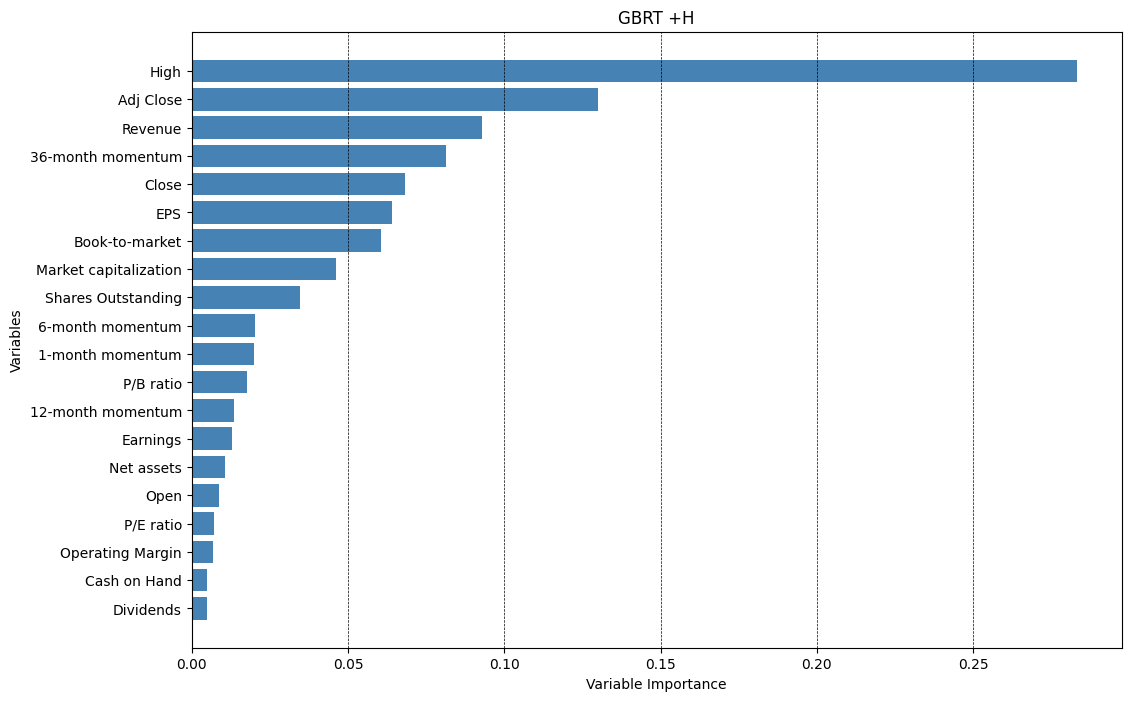

In [15]:
imp = varimp.sort_values('var_imp', ascending=False).head(20)

df_plot = pd.DataFrame({
    'Variable': imp['Variable'],
    'Importance': imp['var_imp']
})

plt.figure(figsize=(12, 8))
plt.barh(df_plot['Variable'], df_plot['Importance'], color='steelblue')
plt.gca().invert_yaxis()


plt.axvline(0.05, color='black', linestyle='--', linewidth=0.5)
plt.axvline(0.1, color='black', linestyle='--', linewidth=0.5)
plt.axvline(0.15, color='black', linestyle='--', linewidth=0.5)
plt.axvline(0.2, color='black', linestyle='--', linewidth=0.5)
plt.axvline(0.25, color='black', linestyle='--', linewidth=0.5)





plt.xlabel('Variable Importance')
plt.ylabel('Variables')
plt.title('GBRT +H')

plt.show()

# Preparations for machine learning portfolios

In [8]:
# The following is a table comparing the estimiates to the true values of each stock for every day in the test set.

# Remember to rerun df_final for all stock!

symbols = df_final.loc[dates_all.index, 'Symbol']  


comparison = pd.DataFrame({
    'Date': dates_all,  
    'y_hat': predictions_all.tolist(),
    'y_true': y_test_list_all.tolist(),
    'Symbol': symbols  
})


comparison['MonthYear'] = comparison['Date'].dt.to_period('M')

comparison = comparison.sort_values(by=['Date', 'Symbol'], ascending=True)
comparison = comparison.set_index(['MonthYear', 'Symbol'])

comparison

Date      y_hat     y_true
MonthYear Symbol                                 
2008-04   A      2008-04-30  18.683558  23.992857
          AAL    2008-04-30   7.865482   3.733256
          AAON   2008-04-30   3.458090   3.544210
          AAP    2008-04-30  30.565983  35.527317
          AAPL   2008-04-30   5.596627   5.692668
...                     ...        ...        ...
2024-08   ZVIA   2024-08-30   2.231920   1.020000
          ZVRA   2024-08-30   8.565678   7.390000
          ZWS    2024-08-30  32.601228  32.099998
          ZYME   2024-08-30  12.685989  12.100000
          ZYXI   2024-08-30  10.275488   7.960000

[518312 rows x 3 columns]

In [9]:
# Save the df for the Diebold-Mariano test

ols= comparison.reset_index()
ols.to_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/Estimater/GBRT Estimates", index = False)

In [10]:
ols = pd.read_csv("C:/Users/CMert/Documents/Data bachelorprojekt/Estimater/GBRT Estimates")

Lad Adj Close være betegnet som P. Afkastraten udregnes ved:

$$ r_{t+1} = \frac{P_{t+1}}{P_t} -1 $$
Og

$$ \hat{r}_{t+1} = \frac{\hat{P}_{t+1}}{P_t} -1 $$

Merafkastsraten udregnes ved:

$$ er_{t+1} = r_{t+1} - r_{f,t+1}  $$
Og

$$ \hat{er}_{t+1} = \hat{r}_{t+1} - r_{f,t+1}  $$


Her er $R_{f,t}$ notation for den risikofrie rate i periode t. Fordi vi arbejder med amerikanske aktier, har vi fundet data for obligationsraten i USA, og benytter dette som den risikofrie rate.
Dataen er fundet her: https://fred.stlouisfed.org/series/DGS20

In [11]:
#Calculate estimiated future return, where distance between each period is one month. Notice that for the return estimate, then for P_t we use the actual adj close price, since at time t it is known: 

comparison = ols

comparison['Date'] = pd.to_datetime(comparison['Date'])


comparison = comparison.sort_values(by=['Symbol', 'Date']).reset_index(drop=True)


comparison["ret_t+1_hat"] = comparison["y_hat"] / comparison.groupby("Symbol")["y_true"].shift(1) - 1
comparison["ret_t+1_true"] = comparison["y_true"] / comparison.groupby("Symbol")["y_true"].shift(1) - 1


comparison_ret_1m = comparison.sort_values(by=['Date', 'Symbol'], ascending=True)


comparison_ret_1m


,MonthYear,Symbol,Date,y_hat,y_true,ret_t+1_hat,ret_t+1_true
0,2008-04,A,2008-04-30,18.683558,23.992857,NaN,NaN
549,2008-04,AAL,2008-04-30,7.865482,3.733256,NaN,NaN
898,2008-04,AAON,2008-04-30,3.458090,3.544210,NaN,NaN
1095,2008-04,AAP,2008-04-30,30.565983,35.527317,NaN,NaN
1292,2008-04,AAPL,2008-04-30,5.596627,5.692668,NaN,NaN
...,...,...,...,...,...,...,...
517813,2024-08,ZVIA,2024-08-30,2.231920,1.020000,1.209821,0.009901
517912,2024-08,ZVRA,2024-08-30,8.565678,7.390000,0.119696,-0.033987
518049,2024-08,ZWS,2024-08-30,32.601228,32.099998,0.005280,-0.010176
518125,2024-08,ZYME,2024-08-30,12.685989,12.100000,0.081500,0.031543


In [12]:
# Drop rows where either 'ret_t-(y_hat)	' or 'ret_t-(y_true)' is NaN
comparison_ret_1m = comparison_ret_1m.dropna(subset=['ret_t+1_hat', 'ret_t+1_true']).reset_index(drop=False)



In [13]:
treasury_securities = pd.read_excel("C:/Users/CMert/Documents/Data bachelorprojekt/Treasury securities.xlsx")

In [14]:
treasury_securities['Date'] = pd.to_datetime(treasury_securities['Date'])
comparison_ret_1m['Date'] = pd.to_datetime(comparison_ret_1m['Date'])

new_comparison = pd.merge(comparison_ret_1m, treasury_securities, on='Date', how='inner')

new_comparison = new_comparison[new_comparison['Treasury Securities'] != 0]

new_comparison['Treasury Securities'] = new_comparison['Treasury Securities'] / (12*100)

new_comparison['exc_ret_t+1_hat'] = new_comparison['ret_t+1_hat']-new_comparison['Treasury Securities']

new_comparison['exc_ret_t+1_true'] = new_comparison['ret_t+1_true']-new_comparison['Treasury Securities']

new_comparison = new_comparison.sort_values(by=['Date', 'Symbol'], ascending=True)

new_comparison = new_comparison.drop("index", axis = 1)

new_comparison


,MonthYear,Symbol,Date,y_hat,y_true,ret_t+1_hat,ret_t+1_true,Treasury Securities,exc_ret_t+1_hat,exc_ret_t+1_true
0,2008-05,A,2008-05-30,22.156428,22.805721,-0.076541,-0.049479,0.003950,-0.080491,-0.053429
1,2008-05,AAL,2008-05-30,4.120593,2.356854,0.103753,-0.368687,0.003950,0.099803,-0.372637
2,2008-05,AAON,2008-05-30,3.959020,3.271587,0.117039,-0.076921,0.003950,0.113089,-0.080871
3,2008-05,AAP,2008-05-30,35.173749,34.281311,-0.009952,-0.035072,0.003950,-0.013902,-0.039022
4,2008-05,AAPL,2008-05-30,6.085014,5.049963,0.068921,-0.112901,0.003950,0.064971,-0.116851
...,...,...,...,...,...,...,...,...,...,...
514462,2024-08,ZVIA,2024-08-30,2.231920,1.020000,1.209821,0.009901,0.003567,1.206255,0.006334
514463,2024-08,ZVRA,2024-08-30,8.565678,7.390000,0.119696,-0.033987,0.003567,0.116130,-0.037554
514464,2024-08,ZWS,2024-08-30,32.601228,32.099998,0.005280,-0.010176,0.003567,0.001713,-0.013742
514465,2024-08,ZYME,2024-08-30,12.685989,12.100000,0.081500,0.031543,0.003567,0.077933,0.027976


In [15]:
treasury_securities['Date'] = pd.to_datetime(treasury_securities['Date'])
comparison_ret_1m['Date'] = pd.to_datetime(comparison_ret_1m['Date'])

new_comparison = pd.merge(comparison_ret_1m, treasury_securities, on='Date', how='inner')

new_comparison = new_comparison[new_comparison['Treasury Securities'] != 0]

new_comparison['Treasury Securities'] = new_comparison['Treasury Securities'] / (12*100)

new_comparison['exc_ret_t+1_hat'] = new_comparison['ret_t+1_hat']-new_comparison['Treasury Securities']

new_comparison['exc_ret_t+1_true'] = new_comparison['ret_t+1_true']-new_comparison['Treasury Securities']

new_comparison = new_comparison.sort_values(by=['Date', 'Symbol'], ascending=True)

new_comparison = new_comparison.drop("index", axis = 1)

new_comparison


,MonthYear,Symbol,Date,y_hat,y_true,ret_t+1_hat,ret_t+1_true,Treasury Securities,exc_ret_t+1_hat,exc_ret_t+1_true
0,2008-05,A,2008-05-30,22.156428,22.805721,-0.076541,-0.049479,0.003950,-0.080491,-0.053429
1,2008-05,AAL,2008-05-30,4.120593,2.356854,0.103753,-0.368687,0.003950,0.099803,-0.372637
2,2008-05,AAON,2008-05-30,3.959020,3.271587,0.117039,-0.076921,0.003950,0.113089,-0.080871
3,2008-05,AAP,2008-05-30,35.173749,34.281311,-0.009952,-0.035072,0.003950,-0.013902,-0.039022
4,2008-05,AAPL,2008-05-30,6.085014,5.049963,0.068921,-0.112901,0.003950,0.064971,-0.116851
...,...,...,...,...,...,...,...,...,...,...
514462,2024-08,ZVIA,2024-08-30,2.231920,1.020000,1.209821,0.009901,0.003567,1.206255,0.006334
514463,2024-08,ZVRA,2024-08-30,8.565678,7.390000,0.119696,-0.033987,0.003567,0.116130,-0.037554
514464,2024-08,ZWS,2024-08-30,32.601228,32.099998,0.005280,-0.010176,0.003567,0.001713,-0.013742
514465,2024-08,ZYME,2024-08-30,12.685989,12.100000,0.081500,0.031543,0.003567,0.077933,0.027976


In [16]:
# Remember to rerun df_final, when adding 'Market cap' since it is standardized:

new_comparison['Date'] = pd.to_datetime(new_comparison['Date'])
df_final['Date'] = pd.to_datetime(df_final['Date'])

final_comparison = pd.merge(new_comparison, df_final[["Date", "Symbol", "Market capitalization"]], on=["Date", "Symbol"], how="inner")


final_comparison = final_comparison.sort_values(by=['Date', 'Symbol'], ascending=True)

In [17]:
final_comparison = final_comparison.rename(columns={'Treasury Securities' : 'Risk free rate'})

In [18]:
# We now limit the df to the following decade 2014-01 and 2023-12
final_comparison = final_comparison[
    (final_comparison["MonthYear"] >= "2014-01") &
    (final_comparison["MonthYear"] <= "2023-12")
]


In [19]:
final_comparison

,MonthYear,Symbol,Date,y_hat,y_true,ret_t+1_hat,ret_t+1_true,Risk free rate,exc_ret_t+1_hat,exc_ret_t+1_true,Market capitalization
136799,2014-01,A,2014-01-31,37.428553,37.276997,-0.017000,-0.020980,0.002792,-0.019791,-0.023772,1.904000e+10
136800,2014-01,AACG,2014-01-31,1.034339,0.375884,1.958129,0.075000,0.002792,1.955337,0.072208,9.062000e+07
136801,2014-01,AAL,2014-01-31,32.156007,34.815441,0.016663,0.100745,0.002792,0.013871,0.097953,6.590000e+09
136802,2014-01,AAON,2014-01-31,13.022471,12.327587,0.064204,0.007418,0.002792,0.061412,0.004626,1.170000e+09
136803,2014-01,AAP,2014-01-31,107.293039,115.128609,0.033812,0.109311,0.002792,0.031020,0.106519,8.060000e+09
...,...,...,...,...,...,...,...,...,...,...,...
484015,2023-12,ZVIA,2023-12-29,3.114031,1.700000,0.549269,-0.154229,0.003500,0.545769,-0.157729,2.600000e+08
484016,2023-12,ZVRA,2023-12-29,7.429221,5.790000,0.134232,-0.116031,0.003500,0.130732,-0.119531,1.583091e+08
484017,2023-12,ZWS,2023-12-29,29.963904,29.427322,0.026543,0.008160,0.003500,0.023043,0.004660,3.760000e+09
484018,2023-12,ZYME,2023-12-29,11.215550,10.840000,0.079456,0.043311,0.003500,0.075956,0.039811,4.900000e+08


In [20]:
# Index every month in order

unique_months = final_comparison['MonthYear'].unique()
unique_months.sort()

month_indices = list(range(1, len(unique_months) + 1))

df_month_merge = pd.DataFrame({
    'MonthYear': unique_months,
    'MonthIndex': month_indices
})

final_comparison = final_comparison.merge(df_month_merge, on='MonthYear', how='left')


In [21]:
final_comparison

,MonthYear,Symbol,Date,y_hat,y_true,ret_t+1_hat,ret_t+1_true,Risk free rate,exc_ret_t+1_hat,exc_ret_t+1_true,Market capitalization,MonthIndex
0,2014-01,A,2014-01-31,37.428553,37.276997,-0.017000,-0.020980,0.002792,-0.019791,-0.023772,1.904000e+10,1
1,2014-01,AACG,2014-01-31,1.034339,0.375884,1.958129,0.075000,0.002792,1.955337,0.072208,9.062000e+07,1
2,2014-01,AAL,2014-01-31,32.156007,34.815441,0.016663,0.100745,0.002792,0.013871,0.097953,6.590000e+09,1
3,2014-01,AAON,2014-01-31,13.022471,12.327587,0.064204,0.007418,0.002792,0.061412,0.004626,1.170000e+09,1
4,2014-01,AAP,2014-01-31,107.293039,115.128609,0.033812,0.109311,0.002792,0.031020,0.106519,8.060000e+09,1
...,...,...,...,...,...,...,...,...,...,...,...,...
347216,2023-12,ZVIA,2023-12-29,3.114031,1.700000,0.549269,-0.154229,0.003500,0.545769,-0.157729,2.600000e+08,120
347217,2023-12,ZVRA,2023-12-29,7.429221,5.790000,0.134232,-0.116031,0.003500,0.130732,-0.119531,1.583091e+08,120
347218,2023-12,ZWS,2023-12-29,29.963904,29.427322,0.026543,0.008160,0.003500,0.023043,0.004660,3.760000e+09,120
347219,2023-12,ZYME,2023-12-29,11.215550,10.840000,0.079456,0.043311,0.003500,0.075956,0.039811,4.900000e+08,120


In [22]:
# Function to add the decile rank of each stock in each month

def decile_ranks(df):
    df = df.sort_values(by='exc_ret_t+1_hat', ascending=True)
    
    df['Decile rank'] = pd.qcut(df['exc_ret_t+1_hat'], 10, labels=False, duplicates='drop')
    return df


final_comparison = final_comparison.groupby('MonthYear', group_keys=False).apply(decile_ranks)


In [23]:
# A dictionray of the stock history of each decile:

decile_dataframes = {}

# Loop through each decile rank
for decile in range(10):
    
    decile_df = final_comparison[final_comparison['Decile rank'] == decile].copy()
    
    decile_df.reset_index(drop=True, inplace=True)
    
    decile_dataframes[f'decile_rank_{decile}'] = decile_df

In [24]:
decile_dataframes['decile_rank_9']

,MonthYear,Symbol,Date,y_hat,y_true,ret_t+1_hat,ret_t+1_true,Risk free rate,exc_ret_t+1_hat,exc_ret_t+1_true,Market capitalization,MonthIndex,Decile rank
0,2014-01,OSBC,2014-01-31,4.795107,4.59557,0.104005,0.058064,0.002792,0.101213,0.055272,6.429000e+07,1,9
1,2014-01,BWEN,2014-01-31,10.205614,9.65000,0.104504,0.044372,0.002792,0.101712,0.041581,1.300000e+08,1,9
2,2014-01,IRS,2014-01-31,10.113564,10.46541,0.105428,0.143885,0.002792,0.102636,0.141093,9.300000e+08,1,9
3,2014-01,RMBS,2014-01-31,9.851905,9.22000,0.105713,0.034792,0.002792,0.102922,0.032001,1.070000e+09,1,9
4,2014-01,SMTI,2014-01-31,13.273225,12.00000,0.106102,0.000000,0.002792,0.103310,-0.002792,2.750000e+06,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34759,2023-12,BCLI,2023-12-29,1.584619,0.35000,4.868959,0.296296,0.003500,4.865459,0.292796,5.992000e+07,120,9
34760,2023-12,UAMY,2023-12-29,1.584619,0.23000,5.338476,-0.080000,0.003500,5.334976,-0.083500,5.179000e+07,120,9
34761,2023-12,USAS,2023-12-29,1.584619,0.22000,5.602579,-0.083333,0.003500,5.599079,-0.086833,1.000000e+08,120,9
34762,2023-12,VERB,2023-12-29,1.558960,0.15800,8.063718,-0.081395,0.003500,8.060218,-0.084895,1.906000e+07,120,9


# Machine learning portfolios

For hvert decildatasæt og derfra for hver måned tilføjer vi to vægte for hver aktie. Vægtene er henholdsvis 'equal weights' og 'market capitalization weights' som udregnes ved:

$$w^{eq} = \frac{1}{N}, $$
hvor N er antallet af aktier for den respektive måned. Vægten baseret på aktiens markedsværdi udregnes ved:

$$w^{mc}_{i} = \frac{mc_i}{\sum_{j = 1}^N mc_j}, $$
hvor $i$ og $j$ er en indexering af aktierne for den respektive måned.

In [25]:

for decile_dfs_key, decile_dfs_value in decile_dataframes.items():
    
    decile_dfs_value.sort_values(['MonthYear'], inplace=True)
    decile_dfs_value.reset_index(drop=True, inplace=True)
    
    # Calculate eq weights:
    decile_dfs_value['eq_weights'] = 1 / decile_dfs_value.groupby('MonthYear')['Symbol'].transform('count')
    
    # Calculate mc weights
    decile_dfs_value['mc_weights'] = decile_dfs_value['Market capitalization'] / decile_dfs_value.groupby('MonthYear')['Market capitalization'].transform('sum')
    
    decile_dataframes[decile_dfs_key] = decile_dfs_value

I artiklen S. 2261 (PDF S. 39) er porteføljens merafkastsrate givet ved:

$$\hat{er}^P_{t+1} = \sum_{i = 1}^N w^P_{i,t} \cdot \hat{er}_{i,t+1} , $$
hvor P angiver den enkelte portefølje, specificeret ved variablerne Decile rank og MonthYear.

In [26]:
# Weighted true excess return at t+1 for each stock:

for decile_dfs_key, decile_dfs_value in decile_dataframes.items():
    # Calculate the product of equal weights and excess return, to find the equal weighted excess return of each stock:
    decile_dfs_value['exc_ret_t+1_true_eq'] = decile_dfs_value['exc_ret_t+1_true'] * decile_dfs_value['eq_weights']
    
    
    # Calculate the product of mc weights and excess return, to find the mc weighted excess return of each stock:
    decile_dfs_value['exc_ret_t+1_true_mc'] = decile_dfs_value['exc_ret_t+1_true'] * decile_dfs_value['mc_weights']
    
    decile_dataframes[decile_dfs_key] = decile_dfs_value

In [27]:
# Weighted true portfolio excess return at t+1:

for decile_dfs_key, decile_dfs_value in decile_dataframes.items():
    
    decile_dfs_value.sort_values(['MonthYear'], inplace=True)
    decile_dfs_value.reset_index(drop=True, inplace=True)
    
    # Calculate true eq portfolio excess return:
    decile_dfs_value['portfolio_true_exc_ret_eq'] = decile_dfs_value.groupby('MonthYear')['exc_ret_t+1_true_eq'].transform('sum')
    
    # Calculate true mc portfolio excess return:
    decile_dfs_value['portfolio_true_exc_ret_mc'] = decile_dfs_value.groupby('MonthYear')['exc_ret_t+1_true_mc'].transform('sum')
    
    decile_dataframes[decile_dfs_key] = decile_dfs_value

In [28]:
# Weighted predicted excess return at t+1 for each stock:

for decile_dfs_key, decile_dfs_value in decile_dataframes.items():
    # Calculate the product of equal weights and excess return, to find the equal weighted excess return of each stock:
    decile_dfs_value['exc_ret_t+1_hat_eq'] = decile_dfs_value['exc_ret_t+1_hat'] * decile_dfs_value['eq_weights']
    
    
    # Calculate the product of mc weights and excess return, to find the mc weighted excess return of each stock:
    decile_dfs_value['exc_ret_t+1_hat_mc'] = decile_dfs_value['exc_ret_t+1_hat'] * decile_dfs_value['mc_weights']
    
    decile_dataframes[decile_dfs_key] = decile_dfs_value

In [29]:
# Weighted predicted portfolio excess return at t+1:

for decile_dfs_key, decile_dfs_value in decile_dataframes.items():
    
    decile_dfs_value.sort_values(['MonthYear'], inplace=True)
    decile_dfs_value.reset_index(drop=True, inplace=True)
    
    # Calculate true eq portfolio excess return:
    decile_dfs_value['portfolio_hat_exc_ret_eq'] = decile_dfs_value.groupby('MonthYear')['exc_ret_t+1_hat_eq'].transform('sum')
    
    # Calculate true mc portfolio excess return:
    decile_dfs_value['portfolio_hat_exc_ret_mc'] = decile_dfs_value.groupby('MonthYear')['exc_ret_t+1_hat_mc'].transform('sum')
    
    decile_dataframes[decile_dfs_key] = decile_dfs_value

In [30]:
# Weighted true return at t+1 for each stock:

for decile_dfs_key, decile_dfs_value in decile_dataframes.items():
    # Calculate the product of equal weights and return, to find the equal weighted return of each stock:
    decile_dfs_value['ret_t+1_true_eq'] = decile_dfs_value['ret_t+1_true'] * decile_dfs_value['eq_weights']
    
    
    # Calculate the product of mc weights and return, to find the mc weighted return of each stock:
    decile_dfs_value['ret_t+1_true_mc'] = decile_dfs_value['ret_t+1_true'] * decile_dfs_value['mc_weights']
    
    decile_dataframes[decile_dfs_key] = decile_dfs_value

In [31]:
# Weighted true portfolio return at t+1:

for decile_dfs_key, decile_dfs_value in decile_dataframes.items():
    
    decile_dfs_value.sort_values(['MonthYear'], inplace=True)
    decile_dfs_value.reset_index(drop=True, inplace=True)
    
    # Calculate true eq portfolio return:
    decile_dfs_value['portfolio_true_ret_eq'] = decile_dfs_value.groupby('MonthYear')['ret_t+1_true_eq'].transform('sum')
    
    # Calculate true mc portfolio return:
    decile_dfs_value['portfolio_true_ret_mc'] = decile_dfs_value.groupby('MonthYear')['ret_t+1_true_mc'].transform('sum')
    
    decile_dataframes[decile_dfs_key] = decile_dfs_value

In [32]:
decile_dataframes['decile_rank_5'].columns

Index(['MonthYear', 'Symbol', 'Date', 'y_hat', 'y_true', 'ret_t+1_hat',
       'ret_t+1_true', 'Risk free rate', 'exc_ret_t+1_hat', 'exc_ret_t+1_true',
       'Market capitalization', 'MonthIndex', 'Decile rank', 'eq_weights',
       'mc_weights', 'exc_ret_t+1_true_eq', 'exc_ret_t+1_true_mc',
       'portfolio_true_exc_ret_eq', 'portfolio_true_exc_ret_mc',
       'exc_ret_t+1_hat_eq', 'exc_ret_t+1_hat_mc', 'portfolio_hat_exc_ret_eq',
       'portfolio_hat_exc_ret_mc', 'ret_t+1_true_eq', 'ret_t+1_true_mc',
       'portfolio_true_ret_eq', 'portfolio_true_ret_mc'],
      dtype='object')

In [33]:
portfolio_returns2 = {}

for decile_dfs_key, decile_dfs_value in decile_dataframes.items():

    portfolio_variables = decile_dfs_value[['MonthYear',
                                   
                                   'portfolio_true_exc_ret_eq',
                                   'portfolio_true_exc_ret_mc',
                                   
                                   'portfolio_hat_exc_ret_eq',
                                   'portfolio_hat_exc_ret_mc',
                                   
                                   'portfolio_true_ret_eq',
                                   'portfolio_true_ret_mc',
                                   
                                   'Decile rank',
                                   'MonthIndex',
                                   
                                   ]].copy()
    
    portfolio_variables = portfolio_variables.drop_duplicates()
    
    portfolio_variables.reset_index(drop=True, inplace=True)
    
    portfolio_returns2[decile_dfs_key] = portfolio_variables


In [34]:
portfolio_returns2['decile_rank_9']

,MonthYear,portfolio_true_exc_ret_eq,portfolio_true_exc_ret_mc,portfolio_hat_exc_ret_eq,portfolio_hat_exc_ret_mc,portfolio_true_ret_eq,portfolio_true_ret_mc,Decile rank,MonthIndex
0,2014-01,0.097878,0.063685,0.389507,0.172197,0.100670,0.066477,9,1
1,2014-02,0.051168,0.054889,0.342045,0.161059,0.053926,0.057648,9,2
2,2014-03,0.015341,0.044960,0.329840,0.193853,0.018099,0.047719,9,3
3,2014-04,0.005907,0.004882,0.421929,0.189610,0.008591,0.007565,9,4
4,2014-05,0.072299,0.030542,0.492139,0.185952,0.074841,0.033084,9,5
...,...,...,...,...,...,...,...,...,...
115,2023-08,-0.019926,-0.058090,0.882295,0.655359,-0.016267,-0.054432,9,116
116,2023-09,-0.107391,-0.099949,1.004583,0.758216,-0.103291,-0.095849,9,117
117,2023-10,0.182547,0.154552,1.233546,0.885295,0.186889,0.158894,9,118
118,2023-11,0.213253,0.195311,1.116665,0.861599,0.217186,0.199244,9,119


Pr. vores finansieringsbog, så gælder: "For any portfolio, P, we define the Sharpe-ratio as excess return relative to standard deviation", jf. S. 57, "Finance 1 and Beyond":

$$Sharpe-ratio^P = \frac{er^P_{t+1}}{\sigma_R^P}$$

In [35]:
#Find Sharpe-ratio of each decile rank dataframe:

for decile_key, portfolio_df in portfolio_returns2.items():
    
    # Calculate average of the true portfolio excess return
    mean_ER_true_eq = portfolio_df['portfolio_true_exc_ret_eq'].mean()
    mean_ER_true_mc = portfolio_df['portfolio_true_exc_ret_mc'].mean()
    
    # Calculate average of the predicted portfolio excess return
    mean_ER_pred_eq = portfolio_df['portfolio_hat_exc_ret_eq'].mean()
    mean_ER_pred_mc = portfolio_df['portfolio_hat_exc_ret_mc'].mean()
    
    # Calculate standard deviation of the true portfolio excess returns
    std_R_true_eq = portfolio_df['portfolio_true_ret_eq'].std()
    std_R_true_mc = portfolio_df['portfolio_true_ret_mc'].std()
    
    # Calculate annualized Sharpe ratio of the true excess returns
    sharpe_ratio_eq = (mean_ER_true_eq / std_R_true_eq) * np.sqrt(12)
    sharpe_ratio_mc = (mean_ER_true_mc / std_R_true_mc) * np.sqrt(12)
    
   
    portfolio_df['Mean_true_ER_eq'] = mean_ER_true_eq
    portfolio_df['Mean_true_ER_mc'] = mean_ER_true_mc
    portfolio_df['Mean_pred_ER_eq'] = mean_ER_pred_eq
    portfolio_df['Mean_pred_ER_mc'] = mean_ER_pred_mc
    portfolio_df['Std_true_ER_eq'] = std_R_true_eq
    portfolio_df['Std_true_ER_mc'] = std_R_true_mc
    portfolio_df['Sharpe_ratio_eq'] = sharpe_ratio_eq
    portfolio_df['Sharpe_ratio_mc'] = sharpe_ratio_mc
    

    portfolio_returns2[decile_key] = portfolio_df

# Zero-net-investment long-short portfolios

At shorte en aktie betyder at du låner aktier, som du vælger at sælge, fordi du forudsiger at de vil falde i pris og dermed kan du købe dem billiger og tjene differencen. At longe en aktie betyder at du køber en aktie, fordi du forventer den stiger i pris og dermed kan tjene differencen. Derfor vil man ifølge zero-net-investment teorien bruge alle ens penge på long-investment, hvor pengene kommer af de aktier man lige har shortet. Dvs. til tid 0 skal ens portefølje have følgende værdi:

$$\sum_{i = 1}^N w_i \cdot P^{long}_{i,0} - \sum_{j = 1}^M w_j \cdot P^{short}_{j,0} = 0$$
Her vælges vægtene for både short- og long-aktierne som før, hvor summen af alle vægte skal være 1. Afkastet for zero-net-investment er dermed til tid t givet ved:

$$\sum_{i = 1}^N w_i \cdot P^{long}_{i,t} - \sum_{j = 1}^M w_j \cdot P^{short}_{j,t} = profit$$

In [36]:
# Create the tables that show the performance of the machine learning portfolios

long_df = portfolio_returns2['decile_rank_9'].copy()
short_df = portfolio_returns2['decile_rank_0'].copy()

long_df['Investment type'] = 'long'
short_df['Investment type'] = 'short'


calc_df = pd.merge(long_df, short_df, on='MonthIndex', suffixes=('_long', '_short'))

In [37]:

# Calculate zero-net investment excess returns
calc_df['true_ER_zni_eq'] = calc_df['portfolio_true_exc_ret_eq_long'] - calc_df['portfolio_true_exc_ret_eq_short']
calc_df['true_ER_zni_mc'] = calc_df['portfolio_true_exc_ret_mc_long'] - calc_df['portfolio_true_exc_ret_mc_short']
calc_df['pred_ER_zni_eq'] = calc_df['portfolio_hat_exc_ret_eq_long'] - calc_df['portfolio_hat_exc_ret_eq_short']
calc_df['pred_ER_zni_mc'] = calc_df['portfolio_hat_exc_ret_mc_long'] - calc_df['portfolio_hat_exc_ret_mc_short']

# Calculate the means
mean_true_ER_zni_eq = calc_df['true_ER_zni_eq'].mean()
mean_true_ER_zni_mc = calc_df['true_ER_zni_mc'].mean()

mean_pred_ER_zni_eq = calc_df['pred_ER_zni_eq'].mean()
mean_pred_ER_zni_mc = calc_df['pred_ER_zni_mc'].mean()

# # Calculate zero-net investment returns that we need for Sharpe ratio
calc_df['true_R_zni_eq'] = calc_df['portfolio_true_ret_eq_long'] - calc_df['portfolio_true_ret_eq_short']
calc_df['true_R_zni_mc'] = calc_df['portfolio_true_ret_mc_long'] - calc_df['portfolio_true_ret_mc_short']


std_true_R_zni_eq = calc_df['true_R_zni_eq'].std()
std_true_R_zni_mc = calc_df['true_R_zni_mc'].std()

# Sharpe ratio
sharpe_ratio_eq_zni = (mean_true_ER_zni_eq / std_true_R_zni_eq) * np.sqrt(12)
sharpe_ratio_mc_zni = (mean_true_ER_zni_mc / std_true_R_zni_mc) * np.sqrt(12)




In [38]:
calc_df

,MonthYear_long,portfolio_true_exc_ret_eq_long,portfolio_true_exc_ret_mc_long,portfolio_hat_exc_ret_eq_long,portfolio_hat_exc_ret_mc_long,portfolio_true_ret_eq_long,portfolio_true_ret_mc_long,Decile rank_long,MonthIndex,Mean_true_ER_eq_long,...,Std_true_ER_mc_short,Sharpe_ratio_eq_short,Sharpe_ratio_mc_short,Investment type_short,true_ER_zni_eq,true_ER_zni_mc,pred_ER_zni_eq,pred_ER_zni_mc,true_R_zni_eq,true_R_zni_mc
0,2014-01,0.097878,0.063685,0.389507,0.172197,0.100670,0.066477,9,1,0.118509,...,0.052558,-2.123681,-1.198826,short,0.059240,0.038647,0.667254,0.250155,0.059240,0.038647
1,2014-02,0.051168,0.054889,0.342045,0.161059,0.053926,0.057648,9,2,0.118509,...,0.052558,-2.123681,-1.198826,short,0.095604,0.090901,1.862408,0.261471,0.095604,0.090901
2,2014-03,0.015341,0.044960,0.329840,0.193853,0.018099,0.047719,9,3,0.118509,...,0.052558,-2.123681,-1.198826,short,0.090049,0.079183,1.854601,0.299635,0.090049,0.079183
3,2014-04,0.005907,0.004882,0.421929,0.189610,0.008591,0.007565,9,4,0.118509,...,0.052558,-2.123681,-1.198826,short,0.017322,-0.000484,1.088526,0.271312,0.017322,-0.000484
4,2014-05,0.072299,0.030542,0.492139,0.185952,0.074841,0.033084,9,5,0.118509,...,0.052558,-2.123681,-1.198826,short,0.046527,0.014940,0.607072,0.272141,0.046527,0.014940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2023-08,-0.019926,-0.058090,0.882295,0.655359,-0.016267,-0.054432,9,116,0.118509,...,0.052558,-2.123681,-1.198826,short,0.068573,-0.003524,4.279384,0.739482,0.068574,-0.003524
116,2023-09,-0.107391,-0.099949,1.004583,0.758216,-0.103291,-0.095849,9,117,0.118509,...,0.052558,-2.123681,-1.198826,short,-0.015302,-0.051634,1.216008,0.835893,-0.015302,-0.051634
117,2023-10,0.182547,0.154552,1.233546,0.885295,0.186889,0.158894,9,118,0.118509,...,0.052558,-2.123681,-1.198826,short,0.148155,0.073556,1.544677,0.961882,0.148155,0.073556
118,2023-11,0.213253,0.195311,1.116665,0.861599,0.217186,0.199244,9,119,0.118509,...,0.052558,-2.123681,-1.198826,short,0.148095,0.161988,1.511501,0.951038,0.148095,0.161988


In [39]:
performance_data = []

for i in range(10):
    decile_key = f'decile_rank_{i}'
    decile_df = portfolio_returns2[decile_key]
    
    mean_pred_ER_eq = decile_df['Mean_pred_ER_eq'].iloc[0]
    mean_true_ER_eq = decile_df['Mean_true_ER_eq'].iloc[0]
    std_true_ER_eq = decile_df['Std_true_ER_eq'].iloc[0]
    sharpe_ratio_eq = decile_df['Sharpe_ratio_eq'].iloc[0]
    
    performance_data.append([mean_pred_ER_eq, mean_true_ER_eq, std_true_ER_eq, sharpe_ratio_eq])

# The zero-net-investments caluclations will be used as H-L row
performance_data.append([mean_pred_ER_zni_eq, mean_true_ER_zni_eq, std_true_R_zni_eq, sharpe_ratio_eq_zni])


columns = ['Pred Avg', 'True Avg', 'SD', 'SR']
index = ['Low(L)', '1', '2', '3', '4', '5', '6', '7', '8', 'High(H)', 'H-L']

ML_performance_eq_table = pd.DataFrame(performance_data, columns=columns, index=index)



In [40]:
ML_performance_eq_table

,Pred Avg,True Avg,SD,SR
Low(L),-3.846576,-0.039705,0.064765,-2.123681
1,-0.050052,-0.017731,0.056488,-1.087382
2,-0.033706,-0.007080,0.051661,-0.474747
3,-0.021477,0.001025,0.051224,0.069334
4,-0.009520,0.008388,0.053378,0.544361
5,0.004960,0.014035,0.054497,0.892123
6,0.025236,0.017437,0.058390,1.034471
7,0.058093,0.020240,0.063268,1.108195
8,0.128930,0.029016,0.070517,1.425411
High(H),8.861566,0.118509,0.417425,0.983471


In [41]:
performance_data = []

for i in range(10):
    decile_key = f'decile_rank_{i}'
    decile_df = portfolio_returns2[decile_key]
    
    mean_pred_ER_mc = decile_df['Mean_pred_ER_mc'].iloc[0]
    mean_true_ER_mc = decile_df['Mean_true_ER_mc'].iloc[0]
    std_true_ER_mc = decile_df['Std_true_ER_mc'].iloc[0]
    sharpe_ratio_mc = decile_df['Sharpe_ratio_mc'].iloc[0]
    
    performance_data.append([mean_pred_ER_mc, mean_true_ER_mc, std_true_ER_mc, sharpe_ratio_mc])

# The zero-net-investments caluclations will be used as H-L row
performance_data.append([mean_pred_ER_zni_mc, mean_true_ER_zni_mc, std_true_R_zni_mc, sharpe_ratio_mc_zni])

columns = ['Pred Avg', 'True Avg', 'SD', 'SR']
index = ['Low(L)', '1', '2', '3', '4', '5', '6', '7', '8', 'High(H)', 'H-L']

ML_performance_mc_table = pd.DataFrame(performance_data, columns=columns, index=index)

In [42]:
ML_performance_mc_table

,Pred Avg,True Avg,SD,SR
Low(L),-0.264825,-0.018189,0.052558,-1.198826
1,-0.049833,-0.006620,0.050153,-0.457242
2,-0.033759,0.001228,0.044465,0.095632
3,-0.021554,0.008741,0.044569,0.679363
4,-0.009851,0.018921,0.049379,1.327363
5,0.004276,0.024879,0.051588,1.670577
6,0.024175,0.029576,0.057465,1.782896
7,0.056549,0.029877,0.065319,1.584516
8,0.127099,0.025645,0.068309,1.300508
High(H),1.740905,0.027984,0.088066,1.100739


In [43]:
ML_performance_eq_table.to_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML_Sharpe_results/GBRT_eq.csv")
ML_performance_mc_table.to_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML_Sharpe_results/GBRT_mc.csv")

# The second table of the machine learning portfolios performance

Maximum drawdown er i artiklen defineret ved:

$$MaxDD = \max _{0 \leq t_{1} \leq t_{2} \leq T}\left(Y_{t_{1}}-Y_{t_{2}}\right),  $$
hvor $Y_t$ er den akkumulerede log afkast givet ved:

$$ r = \log\left(\prod_{i = 1}^{n}(1+r_i) \right)$$

$$ = \sum_{i = 1}^{n} \log \left( 1+r_i \right), $$
hvor n er antallet af porteføljer

In [44]:

# Calculate the maximum drawdown
def max_dd(returns):
    
    draw_downs = []
    exc_ret = returns.copy()
    
    # Calculate cumulative log excess returns
    exc_ret = np.log(1 + exc_ret).cumsum()
    
    
    peak = exc_ret.iloc[0]
    
    for i in range(1, len(exc_ret)):
        current = exc_ret.iloc[i]
        
        if current > peak:
            peak = current  
        else:
            drawdown = peak - current  
            draw_downs.append(drawdown)
    
    if draw_downs:
        max_drawdown = max(draw_downs)
    else:
        max_drawdown = 0  # In the off chance the stock is ever increasing
    
    return max_drawdown

maxdd_eq = max_dd(calc_df['true_ER_zni_eq'])
maxdd_mc = max_dd(calc_df['true_ER_zni_mc'])


maxdd_eq_pct = maxdd_eq * 100
maxdd_mc_pct = maxdd_mc * 100

print("MaxDD EQ: ", maxdd_eq_pct)
print("MaxDD MC: ", maxdd_mc_pct)

MaxDD EQ:  1.5419927457632099
MaxDD MC:  10.670055318219074


# Max 1M loss
I artiklen defineret som den mest extreme, negative månedlige afkast.

In [45]:
max_1m_loss_eq_pct = calc_df['true_ER_zni_eq'].min()*(-100)
max_1m_loss_mc_pct = calc_df['true_ER_zni_mc'].min()*(-100)

print("Max 1M EQ: ", max_1m_loss_eq_pct)
print("Max 1M MC: ", max_1m_loss_mc_pct)

Max 1M EQ:  1.5301649104513106
Max 1M MC:  7.74100706122142


# Turnover

I artiklen er turnover defineret ved:

$$ \frac{1}{T} \sum_{t = 1}^T \left(\sum_{i = 1}^n   \bigg| w_{i,t+1} - \frac{w_{i,t}(1+r_{i,t+1})}{1+ \sum_{j = 1}^n  w_{j,t} \cdot r_{j,t+1}}  \bigg|  \right)  $$

In [46]:
# Get the t+1 weights for both eq and mc weights:

for decile_dfs_key, decile_dfs_value in decile_dataframes.items():
    
    decile_dfs_value.sort_values(['Symbol', 'MonthYear'], inplace=True)
    decile_dfs_value.reset_index(drop=True, inplace=True)
    
    # Create next month's weights for eq_weights and mc_weights, and if they dont exist set to 0
    decile_dfs_value['eq_weights_t+1'] = decile_dfs_value.groupby('Symbol')['eq_weights'].shift(-1).fillna(0)
    decile_dfs_value['mc_weights_t+1'] = decile_dfs_value.groupby('Symbol')['mc_weights'].shift(-1).fillna(0)

    
    decile_dataframes[decile_dfs_key] = decile_dfs_value


In [47]:
def turnover(long_df, short_df, weight_t0, weight_t1, exc_ret_t1):
    turnover_each_month = []
    
    # Combine long and short portfolios into one portfolio
    zero_net = pd.concat([long_df, short_df], ignore_index=True)
    
    zero_net.sort_values(['MonthYear'], inplace=True)
    zero_net.reset_index(drop=True, inplace=True)
    
    months = zero_net['MonthYear'].unique()
    
    for t in months[:-1]:  # Exclude the last month since it has no t+1 weights
        
        current_month = zero_net[zero_net['MonthYear'] == t]
        
        # Calculate the denominator for month t
        denominator = 1 + (current_month[weight_t0] * current_month[exc_ret_t1]).sum()
        
        # Calculate the turnover for each stock
        current_month['fraction'] = (
            current_month[weight_t0] * (1 + current_month[exc_ret_t1]) / denominator
        )
        current_month['abs_diff'] = abs(
            current_month[weight_t1] - current_month['fraction']
        )
        
        # Sum the absolute differences for month t
        turnover_each_month.append(current_month['abs_diff'].sum())
    
    # Calculate the average turnover across all months
    turnover = sum(turnover_each_month) / len(turnover_each_month)
    return turnover


In [48]:
long_df = decile_dataframes['decile_rank_9']
short_df = decile_dataframes['decile_rank_0']


weight_eq = 'eq_weights'
weight_t1_eq = 'eq_weights_t+1'
exc_ret_t1 = 'exc_ret_t+1_true'

turnover_eq = turnover(long_df, short_df, weight_eq, weight_t1_eq, exc_ret_t1)


weight_mc = 'mc_weights'
weight_t1_mc = 'mc_weights_t+1'
exc_ret_t1 = 'exc_ret_t+1_true'

turnover_mc = turnover(long_df, short_df, weight_mc, weight_t1_mc, exc_ret_t1)


turnover_eq_pct = turnover_eq*100
turnover_mc_pct = turnover_mc*100

print("Turnover EQ: ", turnover_eq_pct)
print("Turnover MC: ", turnover_mc_pct)


Turnover EQ:  41.695678201670304
Turnover MC:  46.47805311719422


In [49]:
eq_table_OLS = pd.DataFrame({
    "OLS +H" : [maxdd_eq_pct,
                max_1m_loss_eq_pct,
                turnover_eq_pct
                ]
})


eq_table_OLS.index = ['Max DD(%)', "Max 1M loss(%)", "Turnover(%)"]

In [50]:
eq_table_OLS

,OLS +H
Max DD(%),1.541993
Max 1M loss(%),1.530165
Turnover(%),41.695678


In [51]:
mc_table_OLS = pd.DataFrame({
    "OLS +H" : [maxdd_mc_pct,
                max_1m_loss_mc_pct,
                turnover_mc_pct
                ]
})


mc_table_OLS.index = ['Max DD(%)', "Max 1M loss(%)", "Turnover(%)"]

In [52]:
mc_table_OLS

,OLS +H
Max DD(%),10.670055
Max 1M loss(%),7.741007
Turnover(%),46.478053


In [53]:
eq_table_OLS.to_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML Performance tables/GBRT_eq.csv")
mc_table_OLS.to_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML Performance tables/GBRT_mc.csv")

# Cumulative log returns of portfolio rank 0 and 9

In [54]:
calc_df

,MonthYear_long,portfolio_true_exc_ret_eq_long,portfolio_true_exc_ret_mc_long,portfolio_hat_exc_ret_eq_long,portfolio_hat_exc_ret_mc_long,portfolio_true_ret_eq_long,portfolio_true_ret_mc_long,Decile rank_long,MonthIndex,Mean_true_ER_eq_long,...,Std_true_ER_mc_short,Sharpe_ratio_eq_short,Sharpe_ratio_mc_short,Investment type_short,true_ER_zni_eq,true_ER_zni_mc,pred_ER_zni_eq,pred_ER_zni_mc,true_R_zni_eq,true_R_zni_mc
0,2014-01,0.097878,0.063685,0.389507,0.172197,0.100670,0.066477,9,1,0.118509,...,0.052558,-2.123681,-1.198826,short,0.059240,0.038647,0.667254,0.250155,0.059240,0.038647
1,2014-02,0.051168,0.054889,0.342045,0.161059,0.053926,0.057648,9,2,0.118509,...,0.052558,-2.123681,-1.198826,short,0.095604,0.090901,1.862408,0.261471,0.095604,0.090901
2,2014-03,0.015341,0.044960,0.329840,0.193853,0.018099,0.047719,9,3,0.118509,...,0.052558,-2.123681,-1.198826,short,0.090049,0.079183,1.854601,0.299635,0.090049,0.079183
3,2014-04,0.005907,0.004882,0.421929,0.189610,0.008591,0.007565,9,4,0.118509,...,0.052558,-2.123681,-1.198826,short,0.017322,-0.000484,1.088526,0.271312,0.017322,-0.000484
4,2014-05,0.072299,0.030542,0.492139,0.185952,0.074841,0.033084,9,5,0.118509,...,0.052558,-2.123681,-1.198826,short,0.046527,0.014940,0.607072,0.272141,0.046527,0.014940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2023-08,-0.019926,-0.058090,0.882295,0.655359,-0.016267,-0.054432,9,116,0.118509,...,0.052558,-2.123681,-1.198826,short,0.068573,-0.003524,4.279384,0.739482,0.068574,-0.003524
116,2023-09,-0.107391,-0.099949,1.004583,0.758216,-0.103291,-0.095849,9,117,0.118509,...,0.052558,-2.123681,-1.198826,short,-0.015302,-0.051634,1.216008,0.835893,-0.015302,-0.051634
117,2023-10,0.182547,0.154552,1.233546,0.885295,0.186889,0.158894,9,118,0.118509,...,0.052558,-2.123681,-1.198826,short,0.148155,0.073556,1.544677,0.961882,0.148155,0.073556
118,2023-11,0.213253,0.195311,1.116665,0.861599,0.217186,0.199244,9,119,0.118509,...,0.052558,-2.123681,-1.198826,short,0.148095,0.161988,1.511501,0.951038,0.148095,0.161988


<Axes: xlabel='MonthYear_long'>

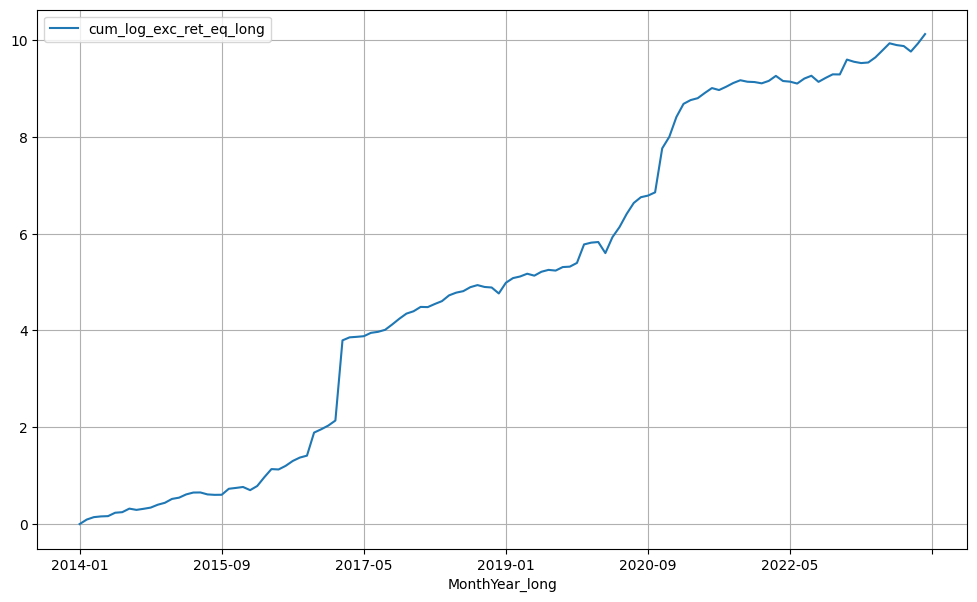

In [55]:
long_df = calc_df.copy()


long_df = long_df.set_index("MonthYear_long")
long_df.sort_values(['MonthYear_long'], inplace = True)


long_df['true_exc_ret_eq_t'] = long_df['portfolio_true_exc_ret_eq_long'].shift(1)


long_df['cum_log_exc_ret_eq_long'] =(np.log(1 + long_df['true_exc_ret_eq_t'])).cumsum()

long_df['cum_log_exc_ret_eq_long'].iloc[0] = 0


long_df[['cum_log_exc_ret_eq_long']].plot(grid=True, figsize=(12, 7))




<Axes: xlabel='MonthYear_long'>

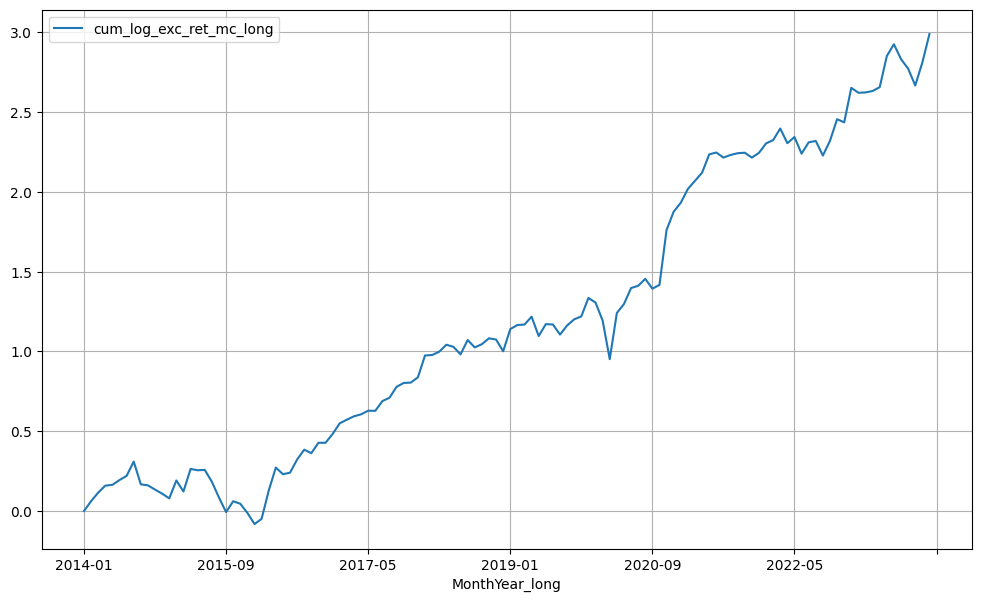

In [60]:
long_df = calc_df.copy()


long_df = long_df.set_index("MonthYear_long")
long_df.sort_values(['MonthYear_long'], inplace = True)


long_df['true_exc_ret_mc_t'] = long_df['portfolio_true_exc_ret_mc_long'].shift(1)


long_df['cum_log_exc_ret_mc_long'] =(np.log(1 + long_df['true_exc_ret_mc_t'])).cumsum()

long_df['cum_log_exc_ret_mc_long'].iloc[0] = 0

long_df[['cum_log_exc_ret_mc_long']].plot(grid=True, figsize=(12, 7))




<Axes: xlabel='MonthYear_short'>

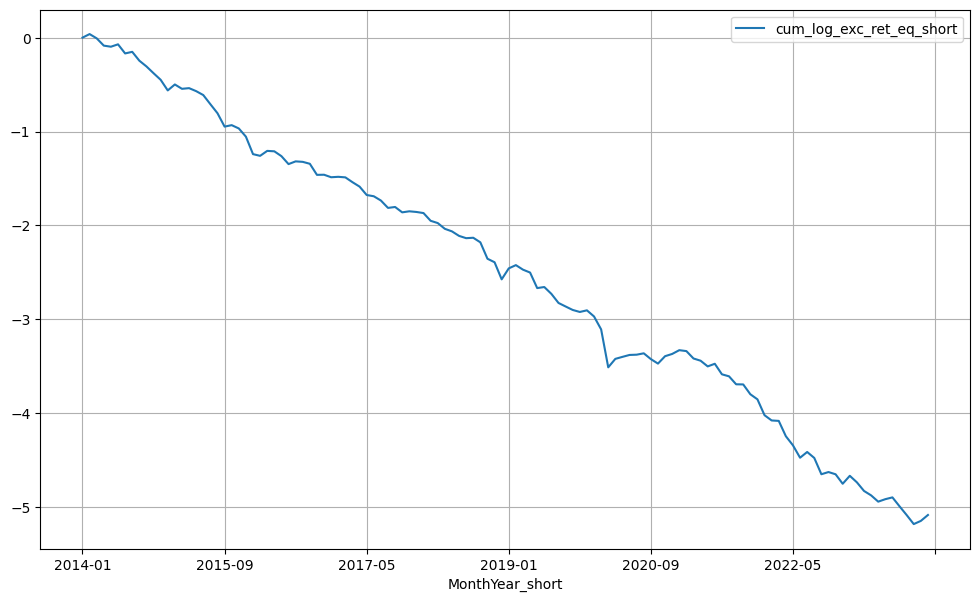

In [57]:
short_df = calc_df.copy()


short_df = long_df.set_index("MonthYear_short")
short_df.sort_values(['MonthYear_short'], inplace = True)


short_df['true_exc_ret_eq_t'] = short_df['portfolio_true_exc_ret_eq_short'].shift(1)


short_df['cum_log_exc_ret_eq_short'] = (np.log(1 + short_df['true_exc_ret_eq_t'])).cumsum()

short_df['cum_log_exc_ret_eq_short'].iloc[0] = 0


short_df[['cum_log_exc_ret_eq_short']].plot(grid=True, figsize=(12, 7))




<Axes: xlabel='MonthYear_short'>

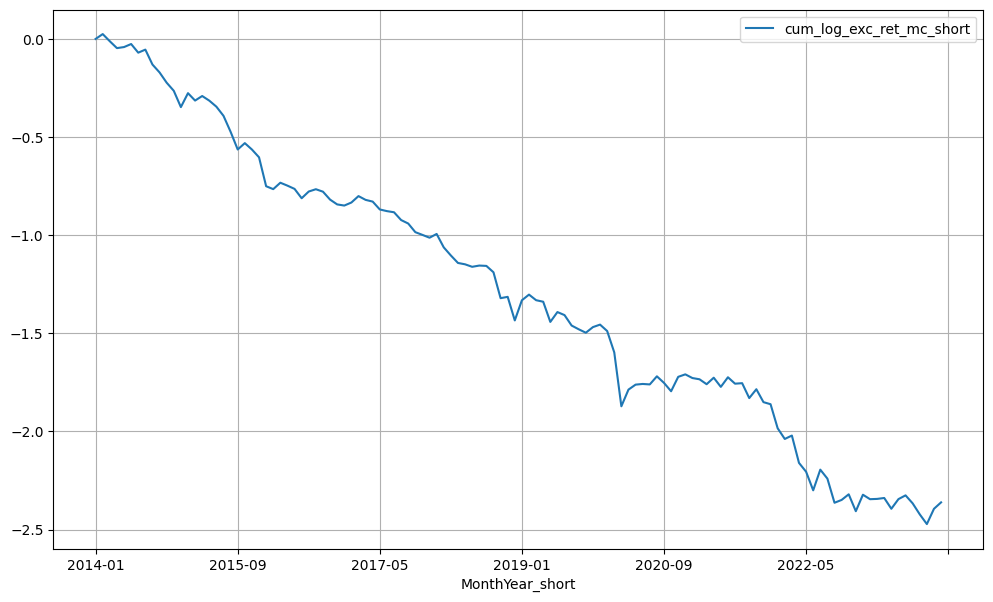

In [61]:
short_df = calc_df.copy()


short_df = long_df.set_index("MonthYear_short")
short_df.sort_values(['MonthYear_short'], inplace = True)


short_df['true_exc_ret_mc_t'] = short_df['portfolio_true_exc_ret_mc_short'].shift(1)


short_df['cum_log_exc_ret_mc_short'] = (np.log(1 + short_df['true_exc_ret_mc_t'])).cumsum()

short_df['cum_log_exc_ret_mc_short'].iloc[0] = 0


short_df[['cum_log_exc_ret_mc_short']].plot(grid=True, figsize=(12, 7))




<Axes: xlabel='MonthYear_long'>

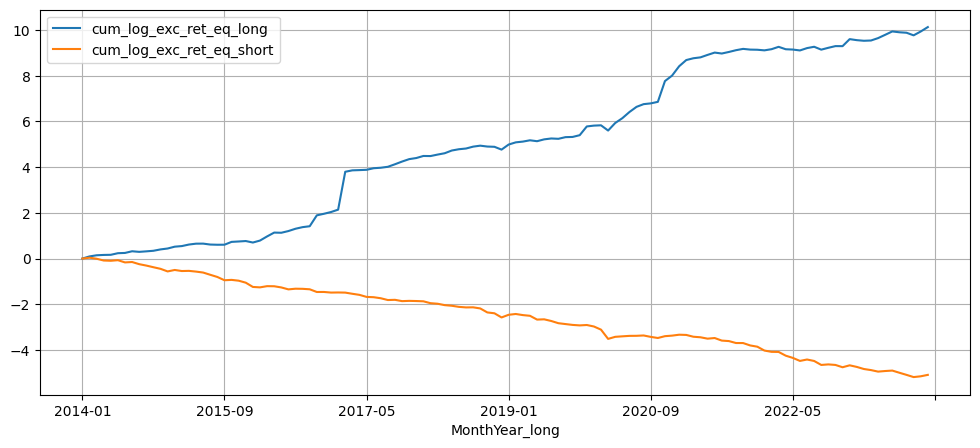

In [58]:
long_short_OLS_eq = pd.merge(long_df[['cum_log_exc_ret_eq_long']], short_df[['cum_log_exc_ret_eq_short']],left_index=True, right_index=True)


long_short_OLS_eq[["cum_log_exc_ret_eq_long", "cum_log_exc_ret_eq_short"]].plot(grid=True,figsize=(12, 5))

In [59]:
long_short_OLS_eq.to_csv(r'C:/Users/CMert/Documents/Data bachelorprojekt/ML grafer/GBRT eq.csv')

<Axes: xlabel='MonthYear_long'>

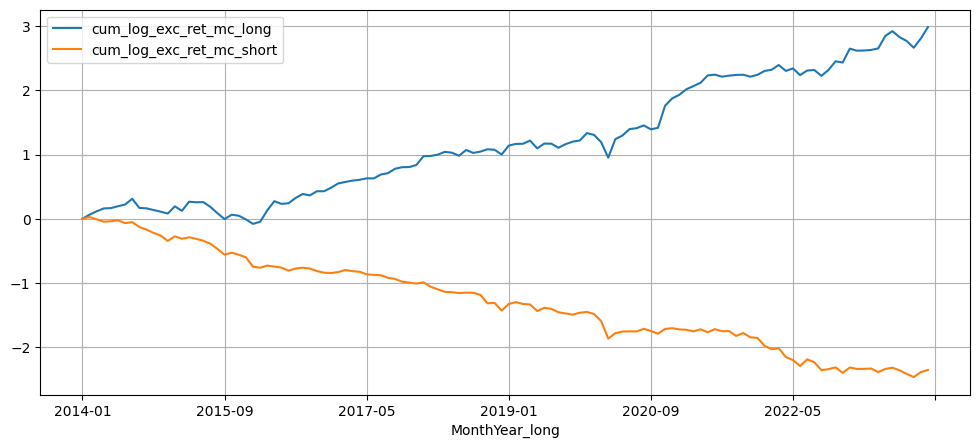

In [62]:

long_short_OLS_mc = pd.merge(long_df[['cum_log_exc_ret_mc_long']], short_df[['cum_log_exc_ret_mc_short']],left_index=True, right_index=True)


long_short_OLS_mc[["cum_log_exc_ret_mc_long", "cum_log_exc_ret_mc_short"]].plot(grid=True,figsize=(12, 5))

In [63]:
long_short_OLS_mc.to_csv(r'C:/Users/CMert/Documents/Data bachelorprojekt/ML grafer/GBRT mc.csv')

# Graveyard